In [1]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sys
import os
import sklearn
import pandas as pd
import utils as utl
import seaborn as sns
from FlowDists import CopulaFlow, RealNVPFlow
from custom_bijectors import Marginal_transforms, nonParam_Marginals
from sklearn import preprocessing as preproc
from UCI_data_preproc.gas import GAS
from UCI_data_preproc.power import POWER
from UCI_data_preproc.miniboone import MINIBOONE
from UCI_data_preproc.hepmass import HEPMASS

In [318]:
datasets = ['GAS', 'POWER', 'HEPMASS', 'MINIBOONE']
num_bijectors={'GAS':5, 'POWER':5, 'HEPMASS':10, 'MINIBOONE':10}
best_model_CPF={'GAS':99500, 'POWER':20000, 'HEPMASS':94000, 'MINIBOONE':7000}
# best_model_CPF={'GAS':49500, 'POWER':47500, 'HEPMASS':94000, 'MINIBOONE':25000}
best_model_RNVP={'GAS':90000, 'POWER':90000, 'HEPMASS':99500, 'MINIBOONE':6000}


def obtainBestModel(dataset):
    if dataset == 'GAS':
        # Load UCI  dataset
        data_tst_native=GAS().tst.x
    elif dataset == 'POWER':
        # Load UCI  dataset
        data_tst_native=POWER().tst.x
    elif dataset == 'HEPMASS':
        # Load UCI  dataset
        data_tst_native=HEPMASS().tst.x
    elif dataset == 'MINIBOONE':
        # Load UCI  dataset
        data_tst_native=MINIBOONE().tst.x

    n_dims = data_tst_native.shape[1]
    
    # Specifying the marginal bijector (from a prelearned distribution)
    marg_attributes=jbl.load(f'saved_models/marginal_params_{dataset}')
    logits,mus,log_sigs=marg_attributes['marg_gmm_params']
    lambdas,min_val=marg_attributes['pw_trans_params']

    # marginal gmms in transformed sapce as the base distribution
    base_dist = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logits),
                               components_distribution=tfd.Normal(loc=mus, scale=tf.exp(log_sigs)))
    # bijector for power transforming
    power_trans_bijec= tfb.Chain([tfb.Shift(shift=min_val), 
                                  tfb.Power(power=1/lambdas),
                                  tfb.Shift(shift=1.),
                                  tfb.Scale(scale=lambdas)])
    # marginal distribution in the native space
    marginals_native=tfd.TransformedDistribution(distribution=base_dist,bijector=power_trans_bijec)
    # sorted samples in the native space
    marginals_samps = marg_attributes['sorted_native_samps']
    
    # Instantiating Copula Flow 
    cpf_obj=CopulaFlow(n_dims,  
                       (marginals_native, marginals_samps), 
                       num_bijectors=num_bijectors[dataset],
                       hidden_layers_size=[min(64,4*n_dims)]*2)
    ckpt=tf.train.Checkpoint(cpf_obj.base_flow)
    ckpt.restore(f'saved_models/{dataset}/CPF1/base_flow-{best_model_CPF[dataset]}-1').assert_consumed()
    
    # Intantiation Real-NVP Flow 
    nvpf_obj = RealNVPFlow(n_dims,
                           num_bijectors=num_bijectors[dataset],
                           hidden_layers_size=[min(64,4*n_dims)]*2)
    ckpt=tf.train.Checkpoint(nvpf_obj.rnvp_flow)
    ckpt.restore(f'saved_models/{dataset}/RNVP1/rnvp_flow-{best_model_RNVP[dataset]}-1').assert_consumed()
    
    return cpf_obj, nvpf_obj, data_tst_native


In [319]:
cpf_obj, nvpf_obj, data_tst_native = obtainBestModel('GAS')
cpf_obj.gen_copula_flow(phase='sampling')

In [322]:
n_tst,n_dims=data_tst_native.shape
samps_cpf=cpf_obj.copula_flow.sample(10000)
samps_nvpf=nvpf_obj.rnvp_flow.sample(10000)

In [248]:
# Defining the validation step
def valid_step(x_batch):
    return cpf_obj.copula_flow.log_prob(x_batch).numpy()

In [249]:
ll_tst_cpf=np.empty((0,))
for i in range(n_tst//1000 +1):
    st_id=i*1000
    en_id = min((i+1)*1000,n_tst)
    dat = data_tst_native[st_id:en_id,:]
    ll=valid_step(dat)
    ll_tst_cpf=np.concatenate([ll_tst_cpf,ll],axis=0)

In [250]:
ll_tst_nvpf=nvpf_obj.rnvp_flow.log_prob(data_tst_native).numpy()

[-20.064381483210393, -19.289255]

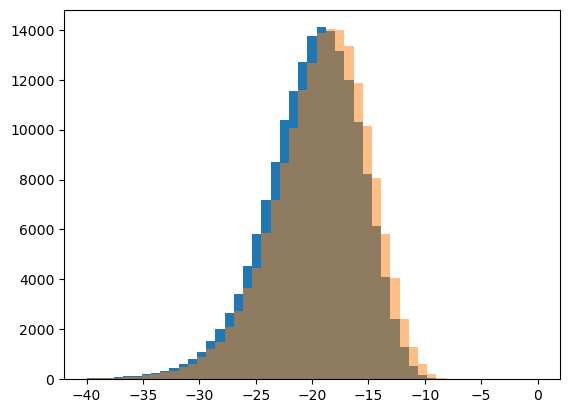

In [257]:
plt.hist(ll_tst_cpf.reshape(-1,1),np.linspace(-40,0,50));
plt.hist(ll_tst_nvpf.reshape(-1,1),np.linspace(-40,0,50),alpha=0.5);
[np.nanmean(ll_tst_cpf), np.mean(ll_tst_nvpf)]

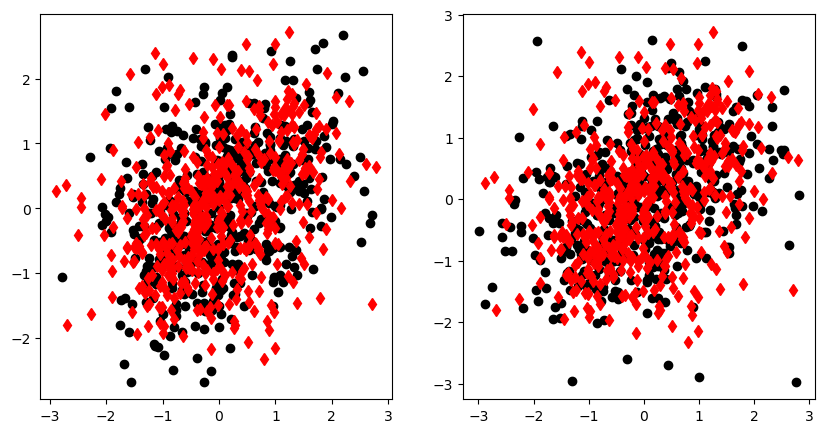

In [258]:
idx1,idx2=np.random.choice(n_dims,2)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(samps_cpf[:500,idx1],samps_cpf[0:500,idx2],'ko')
plt.plot(data_tst_native[:500,idx1],data_tst_native[0:500,idx2],'rd')
plt.subplot(122)
plt.plot(samps_nvpf[:500,idx1],samps_nvpf[0:500,idx2],'ko')
plt.plot(data_tst_native[:500,idx1],data_tst_native[0:500,idx2],'rd')

In [300]:
from collections import defaultdict

In [305]:
CVM_cpf={}
CVM_nvpf={}
for dataset in datasets:
    print(f'Performing CramerVonMisses 2-sample test on {dataset} data.')
    cpf_obj, nvpf_obj, data_tst_native = obtainBestModel(dataset)
    cpf_obj.gen_copula_flow(phase='sampling')
    n_tst,n_dims=data_tst_native.shape
    samps_cpf=cpf_obj.copula_flow.sample(n_tst)
    samps_nvpf=nvpf_obj.rnvp_flow.sample(n_tst)
    CVM_cpf[dataset]=defaultdict(lambda:[])
    CVM_nvpf[dataset]=defaultdict(lambda:[])
    
    for idx in range(n_dims):
        out=sc.stats.cramervonmises_2samp(data_tst_native[:,idx],samps_cpf[:,idx])
        CVM_cpf[dataset]['stats'].append(round(out.statistic,3))
        CVM_cpf[dataset]['pval'].append(round(out.pvalue,3))
        out=sc.stats.cramervonmises_2samp(data_tst_native[:,idx],samps_nvpf[:,idx])
        CVM_nvpf[dataset]['stats'].append(round(out.statistic,3))
        CVM_nvpf[dataset]['pval'].append(round(out.pvalue,3))

Performing CramerVonMisses 2-sample test on GAS data.
Performing CramerVonMisses 2-sample test on POWER data.
Performing CramerVonMisses 2-sample test on HEPMASS data.


C:\Users\tewar\OneDrive\Documents\work\FlowCopula_v2\UCI_data_preproc\hepmass.py:35: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data_train = pd.read_csv(filepath_or_buffer=join(path, "1000_train.csv"), index_col=False)


Performing CramerVonMisses 2-sample test on MINIBOONE data.


In [315]:
for dataset in datasets:
    print([np.mean(CVM_cpf[dataset]['stats']), np.mean(CVM_nvpf[dataset]['stats'])])

[0.677875, 19.663249999999998]
[1.9178333333333333, 39.10166666666667]
[2.0142857142857142, 28.093380952380954]
[0.14544186046511626, 0.7966511627906975]


In [ ]:
out.pvalue

In [320]:
ss = cpf_obj.base_flow.sample(10000).numpy()

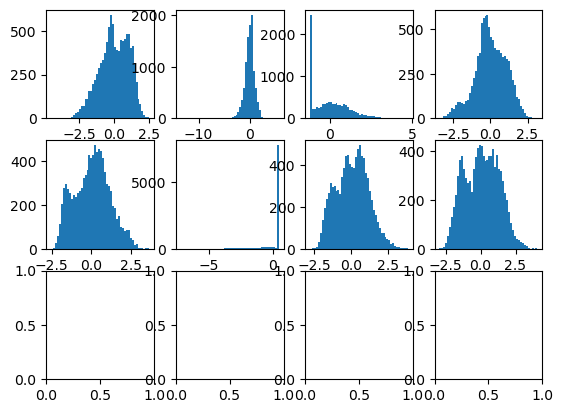

In [323]:
n_cols=4
n_rows=n_dims//n_cols+1
fig,ax=plt.subplots(ncols=n_cols,nrows=n_rows)
for idx in range(n_dims):
    r,c = divmod(idx,n_cols)
#     ax[r,c].hist(ss[:,idx].reshape(-1,1),np.linspace(-4,4,50));
    ax[r,c].hist(ss[:,idx].reshape(-1,1),50);
        

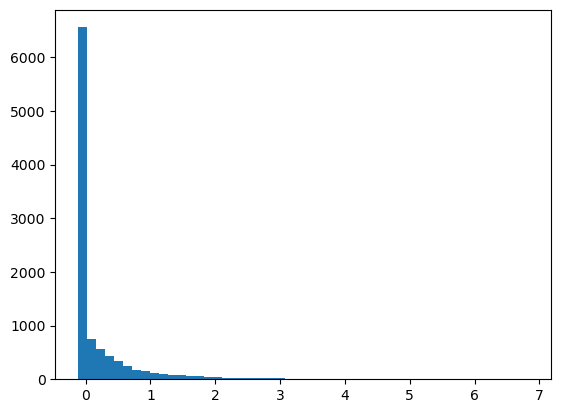

In [291]:
plt.hist(ss[:,0].reshape(-1,1),50);

In [227]:
utl.obtain_KDE_bw(cpf_obj.bijec_non_param.x_arr.numpy(),axis=1)

array([0.26450622, 0.2679166 , 0.26114702, 0.26028937, 0.2677756 ,
       0.25347486], dtype=float32)

In [293]:
ss1=cpf_obj.bijec_non_param.base_dist.sample(1000).numpy()

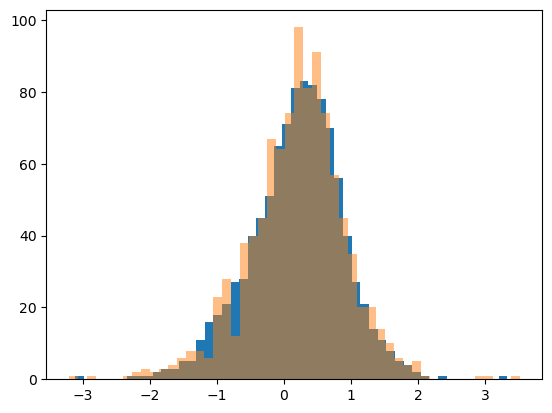

In [299]:
idx=5
plt.hist(cpf_obj.bijec_non_param.x_arr.numpy()[idx,:].reshape(-1,1),50);
plt.hist(ss1[:,idx].reshape(-1,1),50,alpha=0.5);
